In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import classification_report

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os,sys
import copy
from sklearn.metrics import roc_curve, roc_auc_score

sys.path.insert(1, '/projects/li-lab/Yue/SpatialAnalysis/py') ##~wont work, has to start with /Users

import ensembl #from st-net
#%load_ext cudf.pandas
import pandas as pd

#import DataSTNet_test as DataObj
import VTransformerLib_torch as MyVit


/projects/compsci/Yue/Anaconda3/envs/torch_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.set_option('display.max_rows', None)
df_json = pd.read_json('../../output/logs/logVitPretrained_Xenium.json')
df_json

,data,radius,if_froze_vit,learning_rate,weight_decay,batch_size,num_epochs,image_size,patch_size,mlp_head_units,mse_test,mse_valid,mse_valid_best,best_epoch,ifNorm
0,breast_cancer_sample1_rep2,one_cell,False,0.000100,0.000000,128,25,72,12,512-512,0.182894,0.181189,NaN,NaN,NaN
1,breast_cancer_sample1_rep1,one_cell,False,0.000100,0.000000,128,25,72,12,512-512,0.177656,0.176376,NaN,NaN,NaN
2,breast_cancer_sample1_rep2,one_cell,False,0.000100,0.000000,128,500,72,12,512-512,0.209804,0.208204,NaN,NaN,NaN
3,breast_cancer_sample1_rep2,one_cell,False,0.000010,0.000000,128,100,72,12,512-512,0.189160,0.187161,NaN,NaN,NaN
4,breast_cancer_sample1_rep1,one_cell,False,0.000010,0.000000,128,100,72,12,512-512,0.186585,0.185461,NaN,NaN,NaN
5,breast_cancer_sample1_rep1,one_cell,False,0.000100,0.000000,128,500,72,12,512-512,0.214610,0.213174,NaN,NaN,NaN
6,breast_cancer_sample1_rep2,two_cell,False,0.000010,0.000000,128,100,72,12,512-512,0.182485,0.182475,NaN,NaN,NaN
7,breast_cancer_sample1_rep1,two_cell,False,0.000010,0.000000,128,100,72,12,512-512,0.181142,0.180491,NaN,NaN,NaN
8,breast_cancer_sample1_rep2,two_cell,False,0.000010,0.000000,32,100,72,12,512-512,0.190928,0.190358,NaN,NaN,NaN
9,breast_cancer_sample1_rep2,two_cell,False,0.000010,0.000000,32,100,72,12,512-512,0.190928,0.190358,0.171647,9.0,NaN


In [3]:
code_dir = '/projects/li-lab/Yue/SpatialAnalysis/'

gene_intersect_df = pd.read_csv(code_dir+'py/XeniumExperiments/xenium_genes_intersection.csv', index_col = 0)
gene_intersect = gene_intersect_df['0']

In [56]:
print(torch.backends.cudnn.enabled)

True


In [5]:
import DataXeniumBreastCancer as DataObj

using default rep1 data
breast_cancer_sample1_rep1
   ABCC11  ACTA2  ACTG2  ADAM9  ADGRE5  ADH1B  ADIPOQ  AGR3  AHSP  AIF1  ...  \
1     0.0    0.0    0.0    0.0     0.0    0.0     0.0   0.0   0.0   0.0  ...   
2     0.0    0.0    1.0    0.0     0.0    0.0     0.0   2.0   0.0   0.0  ...   
3     0.0    0.0    0.0    0.0     0.0    0.0     0.0   0.0   0.0   0.0  ...   
4     0.0    0.0    0.0    0.0     0.0    0.0     0.0   0.0   0.0   0.0  ...   
5     0.0    0.0    0.0    0.0     0.0    0.0     0.0   0.0   0.0   2.0  ...   

   TUBB2B  TYROBP  UCP1  USP53  VOPP1  VWF  WARS  ZEB1  ZEB2  ZNF562  
1     0.0     0.0   0.0    0.0    0.0  0.0   1.0   0.0   0.0     0.0  
2     0.0     0.0   0.0    3.0    0.0  0.0   0.0   0.0   0.0     0.0  
3     0.0     0.0   0.0    0.0    0.0  0.0   0.0   0.0   0.0     0.0  
4     0.0     0.0   0.0    0.0    0.0  0.0   0.0   0.0   0.0     0.0  
5     0.0     1.0   0.0    2.0    0.0  0.0   0.0   0.0   1.0     0.0  

[5 rows x 313 columns]
(166453, 72, 72, 3

In [6]:
MyVit.image_size = 72  # We'll resize input images to this size
MyVit.batch_size = 512  # We'll resize input images to this size


DataObj.X = np.array(DataObj.X).reshape((len(DataObj.X), 3, MyVit.image_size, MyVit.image_size))

train_data, test_data, train_labels, test_labels = train_test_split(DataObj.X, DataObj.Y_filtered, test_size = 0.2 , random_state=1024)


MyVit.num_class = train_labels.shape[1]
#######remove bias of cell density, stnet norm
from sklearn.preprocessing import normalize

#train_labels_norm = np.log(normalize(train_labels+1, axis=1, norm='l1'))
#test_labels_norm = np.log(normalize(test_labels+1, axis=1, norm='l1'))

#train_labels_norm = np.log(train_labels+1)
#test_labels_norm = np.log(test_labels+1)

x_train = np.array(train_data)
x_test = np.array(test_data)
y_train = np.array(train_labels)
y_test = np.array(test_labels)

print(
    x_train.shape,
    x_test.shape,
    y_train.shape,
    y_test.shape
)

x_train_ids = range(x_train.shape[0])
x_train_ids, x_valid_ids, y_train, y_valid = train_test_split(x_train_ids, y_train, test_size = 0.2 , random_state=1024)

x_valid = x_train[x_valid_ids,:]##oom issues
x_train = x_train[x_train_ids,:]
#x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.2 , random_state=1024)

#train_scaler, x_train = MyVit.norm_img(x_train, scaler = None)
#_, x_valid = MyVit.norm_img(x_valid, train_scaler)
#_, x_test = MyVit.norm_img(x_test, train_scaler)



# Create iterators for the Data loaded using DataLoader module
def np_to_dataLoader(my_x, my_y):
    tensor_x = torch.Tensor(my_x) # transform to torch tensor
    tensor_y = torch.Tensor(my_y)

    my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
    my_dataloader = DataLoader(my_dataset, batch_size = MyVit.batch_size) # create your dataloader
    return my_dataloader


#train_data_loader = np_to_dataLoader(x_train, y_train)
valid_data_loader = np_to_dataLoader(x_valid, y_valid)
test_data_loader = np_to_dataLoader(x_test, y_test)


#train_data_size = x_train.shape[0]
valid_data_size = x_valid.shape[0]
test_data_size = x_test.shape[0]


(133162, 3, 72, 72) (33291, 3, 72, 72) (133162, 313) (33291, 313)


In [7]:
from transformers import ViTImageProcessor
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch32-384")
image_mean, image_std = processor.image_mean, processor.image_std
print(image_mean, image_std)
normalize = transforms.Normalize(mean=image_mean, std=image_std)

image_aug_test = torch.nn.Sequential(
    #transforms.CenterCrop(MyVit.image_size-20),
    #transforms.RandomRotation(degrees=(0, 180)),
    #transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomVerticalFlip(p=0.5),
    normalize,
    transforms.Resize(MyVit.image_size)
)

[0.5, 0.5, 0.5] [0.5, 0.5, 0.5]


In [8]:
MyVit.image_size = 72 

In [9]:
import os
#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:1024"
#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "1024"
torch.cuda.empty_cache()
#print(torch.cuda.memory_summary(device='cuda:0', abbreviated=False))
#os.environ['CUDA_VISIBLE_DEVICES']=''

if torch.cuda.is_available(): 
    dev = "cuda:0" 
else: 
    dev = "cpu"

device = torch.device(dev)

#device = 'cpu'

In [10]:
data_set = 'breast_cancer_sample1_rep1' ##'BC23810' #patient with largest number of voxels


#modl_file = "../saved_models/ViT_stnetData_"+tst_patient+".h5"
modl_file = "../../saved_models/ViT_pretrained_XeniumBreastCancerData_"+data_set+".pt"

modl = torch.load(modl_file, map_location=device)
modl.eval()





ViT(
  (patch_embedding): Conv2d(3, 1024, kernel_size=(32, 32), stride=(32, 32))
  (positional_embedding): PositionalEmbedding1D()
  (transformer): Transformer(
    (blocks): ModuleList(
      (0): Block(
        (attn): MultiHeadedSelfAttention(
          (proj_q): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_k): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_v): Linear(in_features=1024, out_features=1024, bias=True)
          (drop): Dropout(p=0.1, inplace=False)
        )
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (pwff): PositionWiseFeedForward(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        )
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
      

In [11]:

def predict_loader(valid_data_loader):
    pred_val = []
    loss_criterion = nn.MSELoss()
    test_loss = 0.0

    for j, (inputs, labels) in enumerate(valid_data_loader):
        inputs = image_aug_test(inputs)
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass - compute outputs on input data using the model
        
        outputs = modl(inputs)
        # Compute loss

        # Calculate validation accuracy
        #ret, predictions = torch.max(outputs.data, 1)
        #correct_counts = predictions.eq(labels.data.view_as(predictions))
        # Convert correct_counts to float and then compute the mean
        #acc = torch.mean(correct_counts.type(torch.FloatTensor))
        # Compute total accuracy in the whole batch and add to valid_acc
        #valid_acc += acc.item() * inputs.size(0)

        pred_val += list(outputs.data.cpu().numpy())
        
        loss = loss_criterion(outputs, labels)
        # Compute the total loss for the batch and add it to valid_loss
        test_loss += loss.item() * inputs.size(0)
        
    avg_test_loss = test_loss/len(pred_val)
    print(avg_test_loss)
    pred_val = np.array(pred_val)
    return pred_val


In [12]:
#pred_tr = predict_loader(train_data_loader)


In [13]:
pred_te = predict_loader(test_data_loader)

0.1693188353009131


In [14]:
pred_val = predict_loader(valid_data_loader)

0.16975332690492456


In [15]:
test_results = []

for j in range(pred_te.shape[1]):
    #cor_train = np.corrcoef(pred_train[:,j],  y_train[:,j])
    #corr_trains.append(cor_train[0,1])

    cor_test = np.corrcoef(pred_te[:,j],  y_test[:,j])
    test_results.append(cor_test[0,1])



In [16]:
pred_te

array([[0.01554245, 0.3196268 , 0.51254386, ..., 0.18043494, 0.6602806 ,
        0.1343318 ],
       [0.09856669, 0.8577311 , 0.7490829 , ..., 0.40375662, 0.9304363 ,
        0.23958784],
       [0.527556  , 0.7307053 , 0.7851171 , ..., 0.18097958, 0.35063013,
        0.4282881 ],
       ...,
       [0.46750954, 0.82062995, 0.824768  , ..., 0.226861  , 0.43673784,
        0.406228  ],
       [0.7697464 , 0.5753268 , 0.7130353 , ..., 0.09582286, 0.19162454,
        0.551181  ],
       [1.051945  , 0.53046185, 0.7388935 , ..., 0.05246022, 0.0873723 ,
        0.704149  ]], dtype=float32)

(array([8.312095e+06, 1.022361e+06, 6.231950e+05, 2.567840e+05,
        1.218240e+05, 5.810000e+04, 1.982900e+04, 5.322000e+03,
        5.470000e+02, 2.600000e+01]),
 array([0.        , 0.51179938, 1.02359876, 1.53539814, 2.04719752,
        2.55899691, 3.07079629, 3.58259567, 4.09439505, 4.60619443,
        5.11799381]),
 <BarContainer object of 10 artists>)

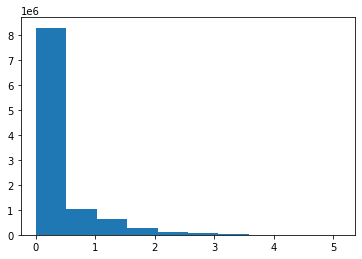

In [17]:
plt.hist(y_test.flatten())

(array([2.6598818e+07, 3.2705340e+06, 1.9880820e+06, 8.2430900e+05,
        3.9205600e+05, 1.8678300e+05, 6.5652000e+04, 1.5342000e+04,
        1.9280000e+03, 7.3000000e+01]),
 array([0.        , 0.5123964 , 1.0247928 , 1.53718919, 2.04958559,
        2.56198199, 3.07437839, 3.58677479, 4.09917118, 4.61156758,
        5.12396398]),
 <BarContainer object of 10 artists>)

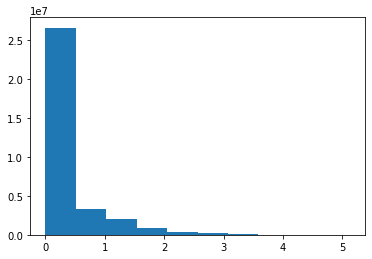

In [18]:
plt.hist(y_train.flatten())

In [19]:
DataObj.Y_filtered

array([[0.        , 0.        , 1.09861229, ..., 0.69314718, 0.69314718,
        0.        ],
       [0.        , 0.        , 0.69314718, ..., 0.        , 0.        ,
        0.        ],
       [0.69314718, 0.69314718, 0.        , ..., 0.        , 0.        ,
        0.69314718],
       ...,
       [0.        , 0.69314718, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

(array([37., 59., 53., 40., 44., 26., 22., 12.,  9., 11.]),
 array([0.01020373, 0.07347444, 0.13674515, 0.20001586, 0.26328658,
        0.32655729, 0.389828  , 0.45309871, 0.51636942, 0.57964013,
        0.64291084]),
 <BarContainer object of 10 artists>)

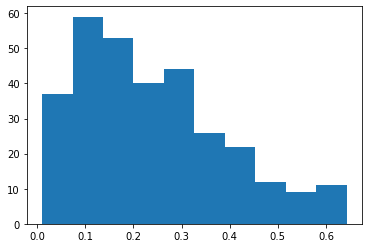

In [20]:
plt.xlabel('Test correlation', fontsize= 20)
plt.ylabel('Frequency', fontsize= 20)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 20)
plt.title('Histogram plot Xenium Breast cancer\n test prediction vs truth', fontsize = 20)
plt.hist(test_results)

In [21]:
val_results = []

for j in range(pred_val.shape[1]):
    #cor_train = np.corrcoef(pred_train[:,j],  y_train[:,j])
    #corr_trains.append(cor_train[0,1])

    cor_test = np.corrcoef(pred_val[:,j],  y_valid[:,j])
    val_results.append(cor_test[0,1])



(array([40., 58., 55., 39., 46., 21., 24., 10., 11.,  9.]),
 array([0.01209892, 0.07523326, 0.1383676 , 0.20150194, 0.26463628,
        0.32777062, 0.39090495, 0.45403929, 0.51717363, 0.58030797,
        0.64344231]),
 <BarContainer object of 10 artists>)

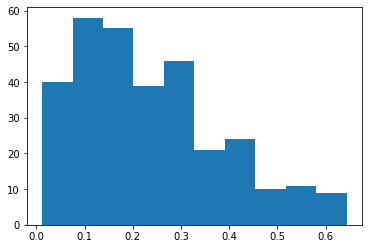

In [22]:
plt.hist(val_results)

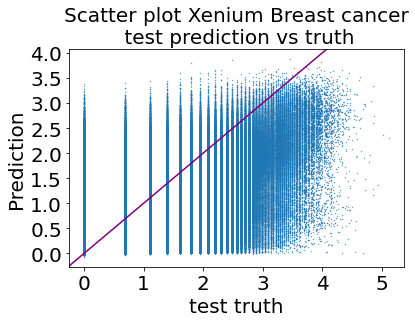

In [23]:
plt.scatter(x = y_test, y = pred_te, s=0.1)
plt.xlabel('test truth', fontsize= 20)
plt.ylabel('Prediction', fontsize= 20)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 20)
plt.title('Scatter plot Xenium Breast cancer\n test prediction vs truth', fontsize = 20)
plt.axline([0, 0], slope=1, color = 'purple')
#plt.xlim([0,0.1])
plt.show()


In [24]:

rep1_results = []
rep1_rmse = []

current_max = 0

for j in range(y_test.shape[1]):
    #cor_train = np.corrcoef(pred_train[:,j],  y_train[:,j])
    #corr_trains.append(cor_train[0,1])

    cor_test = np.corrcoef(pred_te[:,j],  y_test[:,j])
    rep1_results.append(cor_test[0,1])
    if cor_test[0,1] > current_max:
        current_max = cor_test[0,1]
        max_index = j
        
    rmse = np.sqrt(np.mean((pred_te[:,j]-y_test[:,j])**2))
    rep1_rmse.append(rmse)
        
print(max_index)    
print(current_max)
print(gene_intersect[max_index])

170
0.6429108371186643
KRT7


0.6429108371186644


/tmp/ipykernel_33001/836402238.py:16: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  plt.hist2d(x, y, bins=(100, 100), cmap=plt.cm.viridis,density = True, norm=colors.SymLogNorm(0.5))


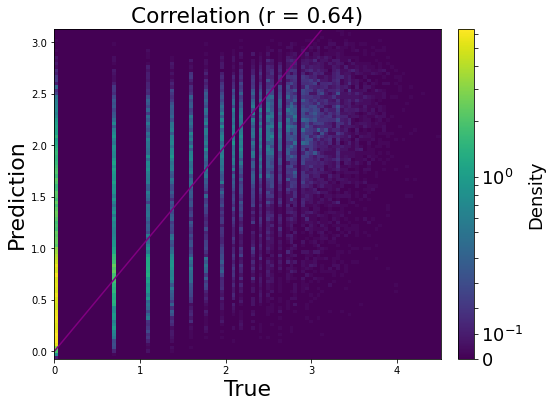

In [25]:
font_size = 22
fig, ax4 = plt.subplots(figsize=(8, 6))

plt.rcParams.update({'font.size': 18})

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import matplotlib.colors as colors


x = y_test[:,max_index]
y = pred_te[:,max_index]

xy = np.vstack([x.flatten(), y.flatten()])
plt.hist2d(x, y, bins=(100, 100), cmap=plt.cm.viridis,density = True, norm=colors.SymLogNorm(0.5))
plt.colorbar(label='Density', pad=0.04, fraction=0.046, ax = ax4)

# density = np.log(np.histogram2d(xy[0], xy[1], bins=50, density=True)[0]+1)
# pcm = ax4.imshow(density, cmap='plasma', origin='lower')
# plt.colorbar(pcm, label='Density', pad=0.04, fraction=0.046, ax = ax4)  # Add a colorbar and adjust its position
# Calculate the correlation coefficient
correlation_coefficient = np.corrcoef(x.flatten(), y.flatten())[0, 1]
plt.axline([0, 0], slope=1, color = 'purple')
#plt.xlim([0,0.0084])
#plt.ylim([0,0.035])

print(correlation_coefficient)
# plt.text(0.02, 0.93, f'r = {correlation_coefficient:.2f}',
#          transform=plt.gca().transAxes, fontsize=18, bbox=dict(facecolor='white', alpha=0.8))
ax4.set_xlabel("True", fontsize = font_size)
ax4.set_ylabel("Prediction",fontsize = font_size)
ax4.set_title(f"Correlation (r = {correlation_coefficient:.2f})")
fig.tight_layout()

(array([27., 59., 54., 45., 47., 36., 23., 10.,  6.,  6.]),
 array([0.01917169, 0.11274024, 0.20630879, 0.29987733, 0.39344588,
        0.48701443, 0.58058298, 0.67415152, 0.76772007, 0.86128862,
        0.95485717]),
 <BarContainer object of 10 artists>)

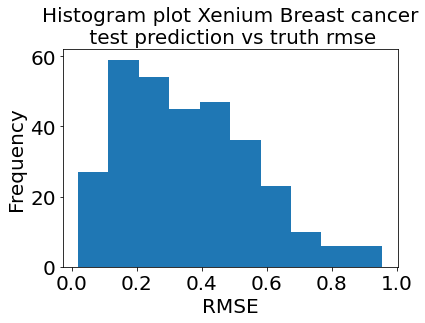

In [26]:
plt.xlabel('RMSE', fontsize= 20)
plt.ylabel('Frequency', fontsize= 20)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 20)
plt.title('Histogram plot Xenium Breast cancer\n test prediction vs truth rmse', fontsize = 20)
plt.hist(rep1_rmse)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'CRHBP'),
  Text(1, 0, 'MPO'),
  Text(2, 0, 'AHSP'),
  Text(3, 0, 'UCP1'),
  Text(4, 0, 'PDCD1'),
  Text(5, 0, 'MUC6'),
  Text(6, 0, 'TCF15'),
  Text(7, 0, 'CYP1A1'),
  Text(8, 0, 'APOBEC3A'),
  Text(9, 0, 'CSF3'),
  Text(10, 0, 'MYBPC1'),
  Text(11, 0, 'GZMK'),
  Text(12, 0, 'SLC4A1'),
  Text(13, 0, 'NDUFA4L2'),
  Text(14, 0, 'LEP'),
  Text(15, 0, 'CXCL5'),
  Text(16, 0, 'CCL20'),
  Text(17, 0, 'SCGB2A1'),
  Text(18, 0, 'SSTR2'),
  Text(19, 0, 'NCAM1')])

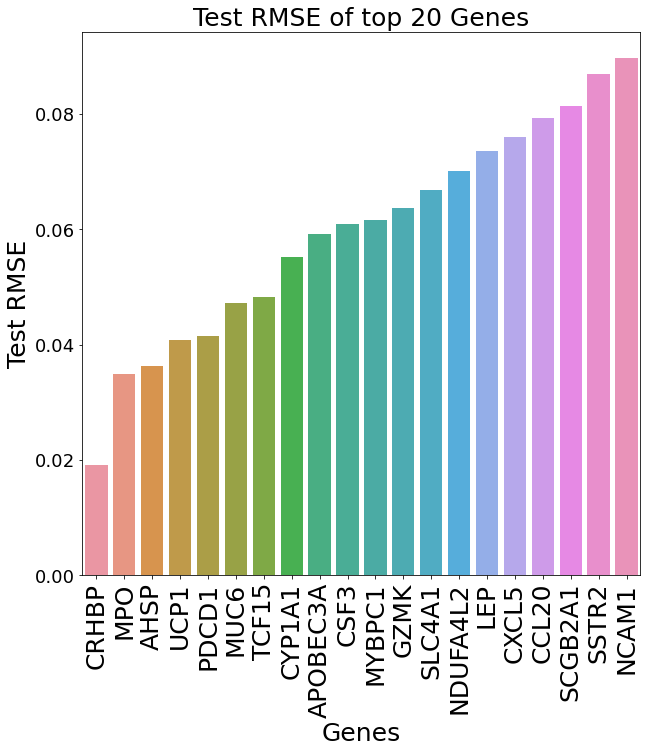

In [27]:

rmse_df = pd.DataFrame(gene_intersect)
rmse_df['Test RMSE'] = rep1_rmse
rmse_df.columns = ['Gene','Test RMSE']
rmse_df = rmse_df.sort_values(by=['Test RMSE'], ascending=True)
top_20_genes = rmse_df.Gene[0:20]

import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
font_size = 25
#my_pal = {"Good": "#d1e231", "Bad": "blue"}
sns.barplot(x="Gene",y="Test RMSE",data=rmse_df.iloc[0:20,],ax=ax)#palette=my_pal)
#sns.violinplot(x="Group",y="TAVAC",data=df,ax=ax,width=0.5, showfliers = False, palette=my_pal)

plt.xlabel('Genes',fontsize=font_size)
plt.ylabel('Test RMSE',fontsize=font_size)
plt.title('Test RMSE of top 20 Genes',fontsize=font_size)
plt.xticks(fontsize=font_size, rotation='vertical')

In [28]:
result_df = pd.DataFrame(gene_intersect)
result_df['corr_test'] = test_results
result_df = result_df.sort_values(by=['corr_test'], ascending=False)
result_df.to_csv('genes_250_corr_test.csv')


In [29]:
result_df.columns = ['Gene','corr']
top_20_genes = result_df.Gene[0:20]
corr_df = pd.DataFrame(test_results)
corr_df.index= pd.Series(gene_intersect)
corr_df = corr_df.loc[top_20_genes,:]

df_stack = pd.DataFrame(corr_df.stack())
df_stack = df_stack.reset_index()
df_stack.columns = ['Gene','patient','Test Corr']

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'KRT7'),
  Text(1, 0, 'CCDC80'),
  Text(2, 0, 'KRT8'),
  Text(3, 0, 'EPCAM'),
  Text(4, 0, 'FOXA1'),
  Text(5, 0, 'GATA3'),
  Text(6, 0, 'MLPH'),
  Text(7, 0, 'ERBB2'),
  Text(8, 0, 'LUM'),
  Text(9, 0, 'FASN'),
  Text(10, 0, 'MMP2'),
  Text(11, 0, 'POSTN'),
  Text(12, 0, 'ANKRD30A'),
  Text(13, 0, 'CCND1'),
  Text(14, 0, 'TACSTD2'),
  Text(15, 0, 'CD9'),
  Text(16, 0, 'CXCL12'),
  Text(17, 0, 'SCD'),
  Text(18, 0, 'FBLN1'),
  Text(19, 0, 'CDH1')])

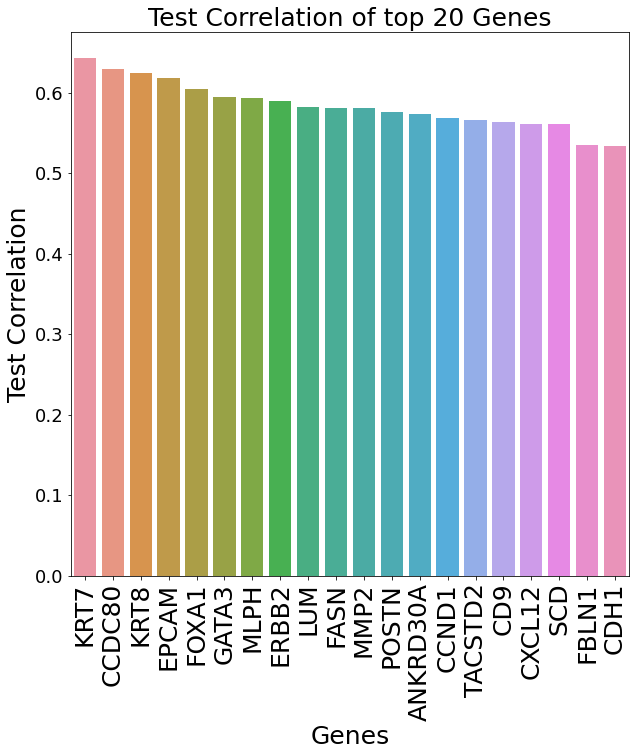

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
font_size = 25
#my_pal = {"Good": "#d1e231", "Bad": "blue"}
sns.barplot(x="Gene",y="Test Corr",data=df_stack,ax=ax )#palette=my_pal)
#sns.violinplot(x="Group",y="TAVAC",data=df,ax=ax,width=0.5, showfliers = False, palette=my_pal)

plt.xlabel('Genes',fontsize=font_size)
plt.ylabel('Test Correlation',fontsize=font_size)
plt.title('Test Correlation of top 20 Genes',fontsize=font_size)
plt.xticks(fontsize=font_size, rotation='vertical')

In [31]:
import importlib;importlib.reload(DataObj)

using default rep1 data
breast_cancer_sample1_rep1
   ABCC11  ACTA2  ACTG2  ADAM9  ADGRE5  ADH1B  ADIPOQ  AGR3  AHSP  AIF1  ...  \
1     0.0    0.0    0.0    0.0     0.0    0.0     0.0   0.0   0.0   0.0  ...   
2     0.0    0.0    1.0    0.0     0.0    0.0     0.0   2.0   0.0   0.0  ...   
3     0.0    0.0    0.0    0.0     0.0    0.0     0.0   0.0   0.0   0.0  ...   
4     0.0    0.0    0.0    0.0     0.0    0.0     0.0   0.0   0.0   0.0  ...   
5     0.0    0.0    0.0    0.0     0.0    0.0     0.0   0.0   0.0   2.0  ...   

   TUBB2B  TYROBP  UCP1  USP53  VOPP1  VWF  WARS  ZEB1  ZEB2  ZNF562  
1     0.0     0.0   0.0    0.0    0.0  0.0   1.0   0.0   0.0     0.0  
2     0.0     0.0   0.0    3.0    0.0  0.0   0.0   0.0   0.0     0.0  
3     0.0     0.0   0.0    0.0    0.0  0.0   0.0   0.0   0.0     0.0  
4     0.0     0.0   0.0    0.0    0.0  0.0   0.0   0.0   0.0     0.0  
5     0.0     1.0   0.0    2.0    0.0  0.0   0.0   0.0   1.0     0.0  

[5 rows x 313 columns]
(166453, 72, 72, 3

<module 'DataXeniumBreastCancer' from '/pod/2/li-lab/users/Yue/SpatialAnalysis/py/XeniumExperiments/DataXeniumBreastCancer.py'>

In [32]:
data_set = 'breast_cancer_sample1_rep2' ##'BC23810' #patient with largest number of voxels
DataObj.X_rep2, DataObj.Y_filtered_rep2, voxel_ids_rep2 = DataObj.load_data(data_set, ifNorm=True)

   ABCC11  ACTA2  ACTG2  ADAM9  ADGRE5  ADH1B  ADIPOQ  AGR3  AHSP  AIF1  ...  \
1     0.0    2.0    0.0    0.0     0.0    1.0     0.0   0.0   0.0   1.0  ...   
2     0.0    1.0    1.0    0.0     0.0    1.0     0.0   0.0   0.0   4.0  ...   
3     0.0    1.0    0.0    1.0     1.0    1.0     0.0   0.0   0.0   1.0  ...   
4     0.0    0.0    1.0    0.0     0.0    1.0     0.0   0.0   0.0   2.0  ...   
5     0.0    0.0    0.0    0.0     0.0    0.0     0.0   0.0   0.0   0.0  ...   

   TUBB2B  TYROBP  UCP1  USP53  VOPP1  VWF  WARS  ZEB1  ZEB2  ZNF562  
1     0.0     1.0   0.0    0.0    0.0  0.0   0.0   0.0   3.0     0.0  
2     0.0     0.0   0.0    0.0    1.0  0.0   0.0   0.0   2.0     1.0  
3     0.0     0.0   0.0    1.0    0.0  0.0   2.0   0.0   1.0     0.0  
4     0.0     1.0   0.0    0.0    4.0  0.0   0.0   1.0   3.0     3.0  
5     0.0     0.0   0.0    0.0    0.0  0.0   0.0   0.0   1.0     1.0  

[5 rows x 313 columns]
(110048, 72, 72, 3)
(110048, 313)


(array([2.7339436e+07, 3.4954740e+06, 2.0912840e+06, 8.4767000e+05,
        3.9063500e+05, 1.8989700e+05, 6.9606000e+04, 1.8364000e+04,
        2.5130000e+03, 1.4500000e+02]),
 array([0.        , 0.50814044, 1.01628087, 1.52442131, 2.03256175,
        2.54070218, 3.04884262, 3.55698306, 4.06512349, 4.57326393,
        5.08140436]),
 <BarContainer object of 10 artists>)

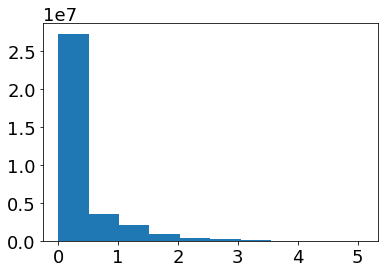

In [33]:
plt.hist(DataObj.Y_filtered_rep2.flatten())

In [34]:
DataObj.X_rep2 = np.array(DataObj.X_rep2).reshape((len(DataObj.X_rep2), 3, MyVit.image_size, MyVit.image_size))

In [35]:
#_, x_rep2 = MyVit.norm_img(DataObj.X_rep2, train_scaler)
x_rep2 = DataObj.X_rep2
#rep2_labels_norm = np.log(DataObj.Y_filtered_rep2+1)
rep2_labels_norm = DataObj.Y_filtered_rep2

y_rep2 = rep2_labels_norm
rep2_data_loader = np_to_dataLoader(x_rep2, y_rep2)


In [36]:
pred_rep2 = predict_loader(rep2_data_loader)

0.24706781388421015


In [37]:
rep2_results = []
rep2_rmse = []

current_max = 0

for j in range(pred_rep2.shape[1]):
    #cor_train = np.corrcoef(pred_train[:,j],  y_train[:,j])
    #corr_trains.append(cor_train[0,1])

    cor_test = np.corrcoef(pred_rep2[:,j],  y_rep2[:,j])
    rep2_results.append(cor_test[0,1])
    if cor_test[0,1] > current_max:
        current_max = cor_test[0,1]
        max_index = j
        
    rmse = np.sqrt(np.mean((pred_rep2[:,j]-y_rep2[:,j])**2))
    rep2_rmse.append(rmse)
        
print(max_index)    
print(current_max)
print(gene_intersect[max_index])

127
0.13217637241468472
FOXA1


In [38]:
row_sums = y_rep2.sum(axis=1)+0.01
y_rep2_norm = y_rep2 / row_sums[:, np.newaxis]
y_rep2_norm

row_sums = pred_rep2.sum(axis=1)+0.01
pred_rep2_norm = pred_rep2 / row_sums[:, np.newaxis]
pred_rep2_norm

array([[0.00194053, 0.00981133, 0.00878314, ..., 0.00496605, 0.01090891,
        0.0031019 ],
       [0.00194365, 0.00986901, 0.00879418, ..., 0.00499827, 0.01092408,
        0.00309531],
       [0.0019429 , 0.0098152 , 0.00878273, ..., 0.00496948, 0.01090849,
        0.00310371],
       ...,
       [0.00052694, 0.00629569, 0.00975526, ..., 0.00348441, 0.0124501 ,
        0.0026786 ],
       [0.0004472 , 0.00541574, 0.00970915, ..., 0.0030227 , 0.0122314 ,
        0.00261788],
       [0.00380441, 0.00809928, 0.0097309 , ..., 0.00285285, 0.00854791,
        0.0043047 ]], dtype=float32)

In [39]:
row_sums = pred_rep2_norm.sum(axis=1)
row_sums

array([0.9998845 , 0.9998851 , 0.9998848 , ..., 0.99980813, 0.9997829 ,
       0.9998164 ], dtype=float32)

In [40]:
cor_test = np.corrcoef(pred_rep2_norm[:,max_index],  y_rep2_norm[:,max_index])
cor_test

array([[1.        , 0.14270434],
       [0.14270434, 1.        ]])

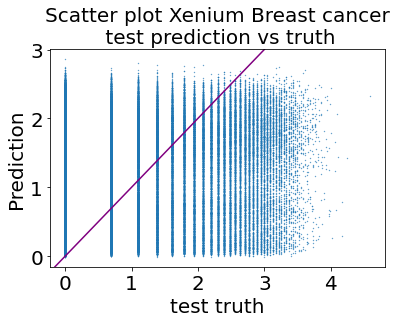

In [41]:
plt.scatter(x = y_rep2[:,max_index], y = pred_rep2[:,max_index], s=0.1)
plt.xlabel('test truth', fontsize= 20)
plt.ylabel('Prediction', fontsize= 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Scatter plot Xenium Breast cancer\n test prediction vs truth', fontsize = 20)
plt.axline([0, 0], slope=1, color = 'purple')
#plt.xlim([0,0.1])
#plt.ylim([0,1])

plt.show()


/tmp/ipykernel_33001/616694615.py:16: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  plt.hist2d(x, y, bins=(500, 500), cmap=plt.cm.viridis,density = True, norm=colors.SymLogNorm(0.5))


0.13217637241468472


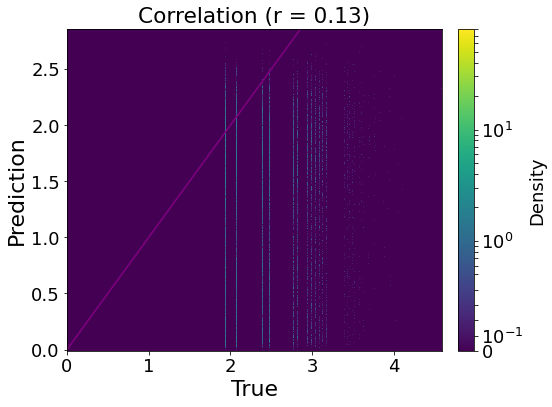

In [42]:
font_size = 22
fig, ax4 = plt.subplots(figsize=(8, 6))

plt.rcParams.update({'font.size': 18})

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import matplotlib.colors as colors


x = y_rep2[:,max_index]
y = pred_rep2[:,max_index]

xy = np.vstack([x.flatten(), y.flatten()])
plt.hist2d(x, y, bins=(500, 500), cmap=plt.cm.viridis,density = True, norm=colors.SymLogNorm(0.5))
plt.colorbar(label='Density', pad=0.04, fraction=0.046, ax = ax4)

# density = np.log(np.histogram2d(xy[0], xy[1], bins=50, density=True)[0]+1)
# pcm = ax4.imshow(density, cmap='plasma', origin='lower')
# plt.colorbar(pcm, label='Density', pad=0.04, fraction=0.046, ax = ax4)  # Add a colorbar and adjust its position
# Calculate the correlation coefficient
correlation_coefficient = np.corrcoef(x.flatten(), y.flatten())[0, 1]
plt.axline([0, 0], slope=1, color = 'purple')
#plt.xlim([0,0.0084])
#plt.ylim([0,0.035])

print(correlation_coefficient)
# plt.text(0.02, 0.93, f'r = {correlation_coefficient:.2f}',
#          transform=plt.gca().transAxes, fontsize=18, bbox=dict(facecolor='white', alpha=0.8))
ax4.set_xlabel("True", fontsize = font_size)
ax4.set_ylabel("Prediction",fontsize = font_size)
ax4.set_title(f"Correlation (r = {correlation_coefficient:.2f})")
fig.tight_layout()

(array([37., 59., 53., 40., 44., 26., 22., 12.,  9., 11.]),
 array([0.01020373, 0.07347444, 0.13674515, 0.20001586, 0.26328658,
        0.32655729, 0.389828  , 0.45309871, 0.51636942, 0.57964013,
        0.64291084]),
 <BarContainer object of 10 artists>)

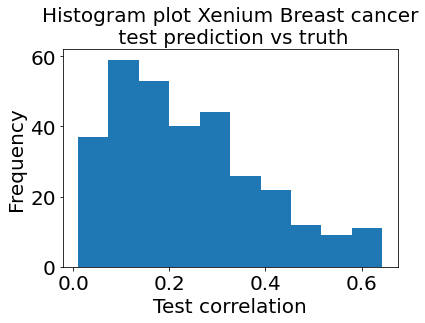

(array([47., 79., 58., 53., 35., 19.,  6.,  4.,  8.,  4.]),
 array([0.01815462, 0.15484123, 0.29152784, 0.42821445, 0.56490106,
        0.70158767, 0.83827428, 0.97496089, 1.1116475 , 1.24833411,
        1.38502072]),
 <BarContainer object of 10 artists>)

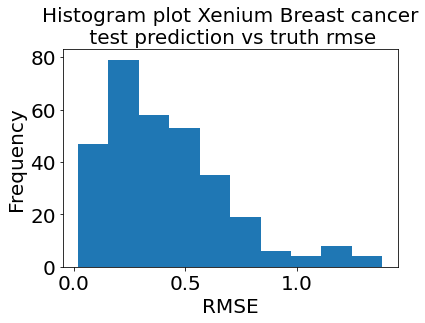

In [44]:
plt.xlabel('RMSE', fontsize= 20)
plt.ylabel('Frequency', fontsize= 20)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 20)
plt.title('Histogram plot Xenium Breast cancer\n test prediction vs truth rmse', fontsize = 20)
plt.hist(rep2_rmse)

In [45]:
np.median(rep2_results)

0.023182647034147227

In [46]:
from scipy.stats import pearsonr,spearmanr

pred_flat = np.array(pred_rep2).flatten()
true_flat = np.array(y_rep2).flatten()
pearsonr(pred_flat,true_flat)


(0.44027552002969816, 0.0)

In [47]:
spearmanr(pred_flat,true_flat)


SpearmanrResult(correlation=0.39506603072403307, pvalue=0.0)

In [48]:
from transformers import ViTFeatureExtractor, ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch32-384')

model.eval()


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_

In [49]:
import sys
sys.path.insert(1, '/projects/li-lab/Yue/SpatialAnalysis/py/PyTorchPretrainedViT') ##~wont work, has to start with /Users
from PyTorchPretrainedViT.pytorch_pretrained_vit import ViT
model = ViT('L_32_imagenet1k', pretrained=True, image_size=384, patches = 32)
model.eval()
MyVit.mlp_head_units = [512]  # Size of the dense layers of the final classifier


modules = []

if len(MyVit.mlp_head_units) > 1:
    for i in range(len(MyVit.mlp_head_units)):

        if i == 0:
            modules.append(nn.Linear(fc_inputs, MyVit.mlp_head_units[i]))

        else:
            modules.append(nn.Linear(MyVit.mlp_head_units[i-1], MyVit.mlp_head_units[i]))

        modules.append(nn.ReLU())
        modules.append(nn.Dropout(0.5))

        if i == (len(MyVit.mlp_head_units)-1):
            modules.append(nn.Linear(MyVit.mlp_head_units[i], 313))
        
else:
    modules.append(nn.Linear(MyVit.mlp_head_units[0], 313))


model.fc = nn.Sequential(*modules)



Resized positional embeddings from torch.Size([1, 145, 1024]) to torch.Size([1, 145, 1024])
Loaded pretrained weights.


In [50]:
model.fc

Sequential(
  (0): Linear(in_features=512, out_features=313, bias=True)
)

In [51]:
model.eval()

ViT(
  (patch_embedding): Conv2d(3, 1024, kernel_size=(32, 32), stride=(32, 32))
  (positional_embedding): PositionalEmbedding1D()
  (transformer): Transformer(
    (blocks): ModuleList(
      (0): Block(
        (attn): MultiHeadedSelfAttention(
          (proj_q): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_k): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_v): Linear(in_features=1024, out_features=1024, bias=True)
          (drop): Dropout(p=0.1, inplace=False)
        )
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (pwff): PositionWiseFeedForward(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        )
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
      

In [52]:
pred_df = pd.DataFrame()

pred_df = pd.concat([pred_df, pd.DataFrame(np.array(pred_rep2))], ignore_index=True)
    
pred_df.columns = gene_intersect
pred_df.index = voxel_ids_rep2

pred_df.head()


0,ABCC11,ACTA2,ACTG2,ADAM9,ADGRE5,ADH1B,ADIPOQ,AGR3,AHSP,AIF1,...,TUBB2B,TYROBP,UCP1,USP53,VOPP1,VWF,WARS,ZEB1,ZEB2,ZNF562
9822,0.168147,0.850153,0.761059,0.574449,0.227267,0.715165,0.248895,0.091939,0.002390,0.584745,...,0.063073,0.139815,0.006763,0.323268,0.517052,0.243930,0.326314,0.430308,0.945257,0.268780
8729,0.169234,0.859298,0.765713,0.578628,0.227989,0.709889,0.243549,0.091821,0.002406,0.586866,...,0.063416,0.140080,0.006805,0.325014,0.519978,0.246731,0.328155,0.435201,0.951164,0.269509
101318,0.168840,0.852950,0.763228,0.576532,0.227745,0.716866,0.249210,0.092192,0.002398,0.586095,...,0.063292,0.140214,0.006787,0.324413,0.518577,0.244823,0.327196,0.431853,0.947958,0.269715
9782,0.725758,0.466224,0.549401,0.625994,0.049793,0.033393,0.005828,0.112033,0.001386,0.100452,...,0.085071,0.014704,0.002504,0.537138,0.510886,0.097409,0.324575,0.086012,0.169158,0.494111
99417,0.168644,0.852471,0.763223,0.576035,0.228105,0.716407,0.249065,0.092113,0.002397,0.586501,...,0.063239,0.140254,0.006779,0.324179,0.518735,0.244639,0.327351,0.431697,0.948086,0.269595


In [53]:
pred_df.to_csv('ViT_xenium_rep2_prediction_allGenes.csv')

In [54]:
data_set = 'breast_cancer_sample1_rep1' ##'BC23810' #patient with largest number of voxels
DataObj.X_rep1, DataObj.Y_filtered_rep1, voxel_ids_rep1 = DataObj.load_data(data_set, ifNorm=True)
DataObj.X_rep1 = np.array(DataObj.X_rep1).reshape((len(DataObj.X_rep1), 3, MyVit.image_size, MyVit.image_size))

rep1_data_loader = np_to_dataLoader(DataObj.X_rep1, DataObj.Y_filtered_rep1)
pred_rep1 = predict_loader(rep1_data_loader)

pred_df = pd.DataFrame()

pred_df = pd.concat([pred_df, pd.DataFrame(np.array(pred_rep1))], ignore_index=True)
    
pred_df.columns = gene_intersect
pred_df.index = voxel_ids_rep1

pred_df.head()


   ABCC11  ACTA2  ACTG2  ADAM9  ADGRE5  ADH1B  ADIPOQ  AGR3  AHSP  AIF1  ...  \
1     0.0    0.0    0.0    0.0     0.0    0.0     0.0   0.0   0.0   0.0  ...   
2     0.0    0.0    1.0    0.0     0.0    0.0     0.0   2.0   0.0   0.0  ...   
3     0.0    0.0    0.0    0.0     0.0    0.0     0.0   0.0   0.0   0.0  ...   
4     0.0    0.0    0.0    0.0     0.0    0.0     0.0   0.0   0.0   0.0  ...   
5     0.0    0.0    0.0    0.0     0.0    0.0     0.0   0.0   0.0   2.0  ...   

   TUBB2B  TYROBP  UCP1  USP53  VOPP1  VWF  WARS  ZEB1  ZEB2  ZNF562  
1     0.0     0.0   0.0    0.0    0.0  0.0   1.0   0.0   0.0     0.0  
2     0.0     0.0   0.0    3.0    0.0  0.0   0.0   0.0   0.0     0.0  
3     0.0     0.0   0.0    0.0    0.0  0.0   0.0   0.0   0.0     0.0  
4     0.0     0.0   0.0    0.0    0.0  0.0   0.0   0.0   0.0     0.0  
5     0.0     1.0   0.0    2.0    0.0  0.0   0.0   0.0   1.0     0.0  

[5 rows x 313 columns]
(166453, 72, 72, 3)
(166453, 313)
0.16941061672664878


0,ABCC11,ACTA2,ACTG2,ADAM9,ADGRE5,ADH1B,ADIPOQ,AGR3,AHSP,AIF1,...,TUBB2B,TYROBP,UCP1,USP53,VOPP1,VWF,WARS,ZEB1,ZEB2,ZNF562
152999,0.155105,0.858469,0.778252,0.560499,0.243849,0.699783,0.238050,0.087018,0.002312,0.604211,...,0.061642,0.141637,0.006218,0.312467,0.532457,0.256473,0.341822,0.436253,0.978183,0.268439
13638,0.153924,0.809356,0.728512,0.534708,0.221122,0.662453,0.230566,0.085654,0.002244,0.562752,...,0.059886,0.131761,0.006078,0.299985,0.494040,0.236136,0.318065,0.405836,0.904262,0.252719
10860,0.095596,0.487798,0.467277,0.294119,0.160844,0.161767,0.041057,0.034633,0.001230,0.345575,...,0.046711,0.065152,0.001713,0.165639,0.335983,0.175387,0.271657,0.209458,0.547754,0.166014
150400,0.108044,0.663177,0.611763,0.405665,0.198835,0.484667,0.165469,0.062886,0.001707,0.485652,...,0.048012,0.104739,0.004126,0.224494,0.414842,0.201623,0.284207,0.322983,0.762521,0.197162
112977,0.135647,0.756375,0.695934,0.489505,0.222214,0.625646,0.220266,0.078569,0.002054,0.548930,...,0.054756,0.125754,0.005472,0.274524,0.475074,0.221926,0.308391,0.379480,0.870732,0.235173


In [55]:
pred_df.to_csv('ViT_xenium_rep1_prediction_allGenes.csv')